In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from load import load_interventions, load_aggregated, load_topics
import pickle
import seaborn as sns

# get aggregated covid daily data

In [2]:
# import raw data
covid = pd.read_csv('./data/WHO-COVID-19-global-data.csv')
covid.drop(columns=['Country_code','WHO_region'], inplace=True)
covid = covid[covid['Date_reported']<'2020-08-01']
covid.head()

,Date_reported,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,Afghanistan,0,0,0,0
1,2020-01-04,Afghanistan,0,0,0,0
2,2020-01-05,Afghanistan,0,0,0,0
3,2020-01-06,Afghanistan,0,0,0,0
4,2020-01-07,Afghanistan,0,0,0,0


In [3]:
# use the weighted average as stated in the paper, pay attention to the country name in the origin data
English_country = ['United States of America','The United Kingdom','Canada','Australia','South Africa','Ireland','New Zealand']
English_dict={'United States of America':0.689,'The United Kingdom':0.161,'Canada':0.058,\
              'Australia':0.054,'South Africa':0.015, 'Ireland':0.012,'New Zealand':0.011}
French_country = ['France','Canada','Cameroon','Belgium','Senegal','Benin','Switzerland']
French_dict = {'France':0.629,'Canada':0.101,'Cameroon':0.092,'Belgium':0.079,'Senegal':0.043,\
               'Benin':0.038,'Switzerland':0.018}
German_country = ['Germany','Austria','Switzerland']
German_dict = {'Germany':0.87,'Austria':0.087,'Switzerland':0.063}

<AxesSubplot:>

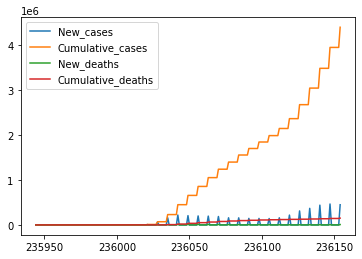

In [4]:
# US data is weird, need further adjustment
covid[covid['Country'] == 'United States of America'].plot()

In [5]:
def weight_sum(df, language):
    res = np.zeros(4) # seven columns that we care
    if language=='English':
        for _, row in df.iterrows():
            weight = English_dict[row['Country']]
            res += weight*row[2:]
        
    elif language=='French':
        for _, row in df.iterrows():
            weight = French_dict[row['Country']]
            res += weight*row[2:]
        
    elif language=='German':
        for _, row in df.iterrows():
            weight = German_dict[row['Country']]
            res += weight*row[2:]
    else:
        print('Invalid language')
        return
    
    return res

In [6]:
# data integration
English = covid[covid['Country'].isin(English_country)].groupby('Date_reported').apply(weight_sum, language='English')
French = covid[covid['Country'].isin(French_country)].groupby('Date_reported').apply(weight_sum, language='French')
German = covid[covid['Country'].isin(German_country)].groupby('Date_reported').apply(weight_sum, language='German')
Japanese = covid[covid['Country'] == 'Japan'].set_index('Date_reported').drop(columns=['Country'])
Italian = covid[covid['Country'] == 'Italy'].set_index('Date_reported').drop(columns=['Country'])
Dutch = covid[covid['Country'] == 'Netherlands'].set_index('Date_reported').drop(columns=['Country'])
Swedish = covid[covid['Country'] == 'Sweden'].set_index('Date_reported').drop(columns=['Country'])
Korean = covid[covid['Country'] == 'Republic of Korea'].set_index('Date_reported').drop(columns=['Country'])
Finnish = covid[covid['Country'] == 'Finland'].set_index('Date_reported').drop(columns=['Country'])
Norwegian = covid[covid['Country'] == 'Norway'].set_index('Date_reported').drop(columns=['Country'])
Danish = covid[covid['Country'] == 'Denmark'].set_index('Date_reported').drop(columns=['Country'])
Serbian = covid[covid['Country'] == 'Serbia'].set_index('Date_reported').drop(columns=['Country'])

In [7]:
# save as a pickle file
covid_agg = {"en":English, "fr":French, "de":German, "ja":Japanese, "it":Italian, "nl":Dutch, "ko":Korean,\
            "no":Norwegian, "fi":Finnish, "sv": Swedish, "sr":Serbian, "da":Danish}
with open('./data/covid_agg_who.pickle', 'wb') as handle:
    pickle.dump(covid_agg, handle, protocol=pickle.HIGHEST_PROTOCOL)

# data processing and visulization

### change point|

In [8]:
# recode important time point
interventions = load_interventions("./data/interventions.csv")
interventions['fr']

{'1st case': Timestamp('2020-01-24 00:00:00'),
 '1st death': Timestamp('2020-02-14 00:00:00'),
 'School closure': Timestamp('2020-03-14 00:00:00'),
 'Public events banned': Timestamp('2020-03-13 00:00:00'),
 'Lockdown': Timestamp('2020-03-17 00:00:00'),
 'Mobility': Timestamp('2020-03-16 00:00:00'),
 'Normalcy': Timestamp('2020-07-02 00:00:00')}

### topic_df

codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]

In [9]:
topics_df, topics = load_topics('./data/topics_linked.csv.xz')
topics_df.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,Geography.Regions.Americas.North America,STEM.STEM*,Culture.Performing arts,Culture.Literature,History and Society.Politics and government,Geography.Regions.Africa.Northern Africa,STEM.Earth and environment,Geography.Regions.Africa.Central Africa,STEM.Medicine & Health,STEM.Libraries & Information,Geography.Regions.Europe.Europe*,Geography.Regions.Europe.Western Europe,Culture.Media.Radio,STEM.Space,Culture.Visual arts.Comics and Anime,STEM.Technology,Culture.Internet culture,Culture.Media.Software,Geography.Regions.Asia.East Asia,Geography.Regions.Europe.Southern Europe,STEM.Biology,Culture.Food and drink,History and Society.Business and economics,Culture.Visual arts.Fashion,Geography.Regions.Americas.Central America,Geography.Geographical,Geography.Regions.Oceania,STEM.Physics,Culture.Media.Films,Geography.Regions.Asia.South Asia,History and Society.Transportation,History and Society.History,Geography.Regions.Africa.Western Africa,Culture.Media.Media*,Geography.Regions.Americas.South America,Culture.Linguistics,STEM.Computing,Culture.Biography.Biography*,Culture.Philosophy and religion,Culture.Sports,Geography.Regions.Africa.Southern Africa,Culture.Visual arts.Visual arts*,Geography.Regions.Africa.Eastern Africa,History and Society.Society,STEM.Engineering,STEM.Mathematics,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q5465542


In [33]:
# all pages name, could be used to do the keyword search
topics_df['index']

0                          Rosmalen
1                      Commelinales
2             Transport_in_Honduras
3                            QuakeC
4                      Food_writing
                     ...           
4306121             Faimaala_Filipo
4306122              Jonathan_Horne
4306123             Steven_Da_Costa
4306124    The_Silence_of_Dr._Evans
4306125                    Qiao_Jie
Name: index, Length: 4306126, dtype: object

In [10]:
topics_df.shape

(4306126, 66)

In [11]:
# basically we can get the page name and its related topic, using api to get pageview data
health_related = topics_df[topics_df['STEM.Medicine & Health']==True]
health_related.shape

(63878, 66)

In [12]:
topics

['Culture.Biography.Biography*',
 'Culture.Biography.Women',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'Geography.Regions.Africa.Africa*',
 'Geography.Regions.Africa.Central Africa',
 'Geography.Regions.Africa.Eastern Africa',
 'Geography.Regions.Africa.Northern Africa',
 'Geography.Regions.Africa.Southern Africa',
 'Geography.Regions.Africa.Western Africa',
 'Geography.Regions.Americas.Central America',
 'Geography.Regions.Americas.North

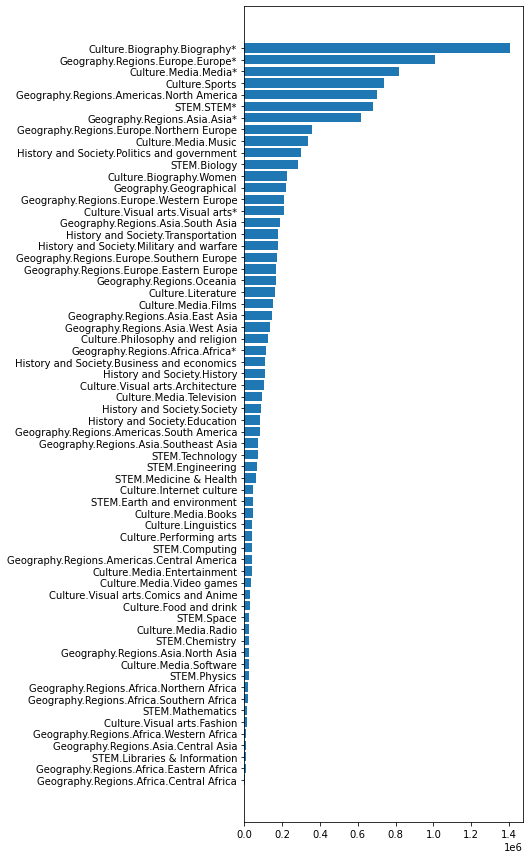

In [13]:
n_pages = [topics_df[topics_df[topic]==True].shape[0] for topic in topics_df.columns[1:-1]]
topic_and_npages = sorted(list(zip(n_pages, topics_df.columns[1:-1])))
n_pages, topic_name = zip(*topic_and_npages)
plt.figure(figsize=(5,15))
plt.barh(topic_name, n_pages)
plt.show()

### covid df

In [14]:
with open('./data/covid_agg_who.pickle', 'rb') as handle:
    covid = pickle.load(handle)

In [15]:
covid['en'].head()

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,
2020-01-03,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0


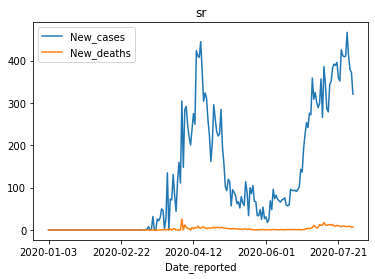

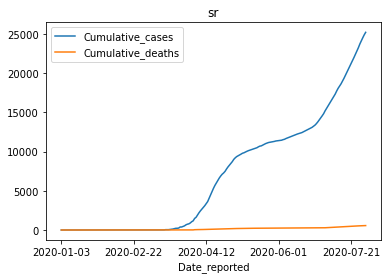

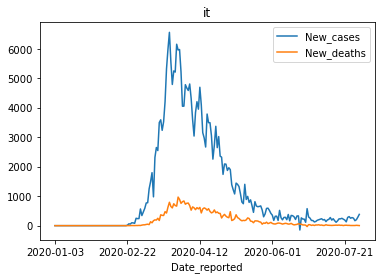

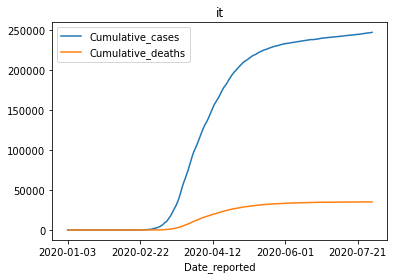

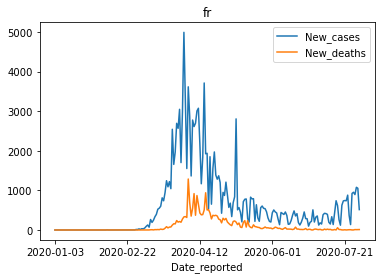

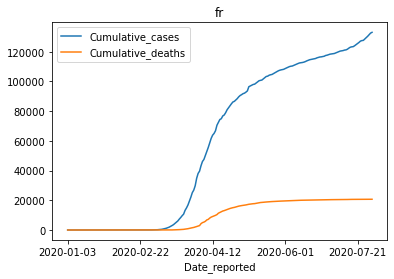

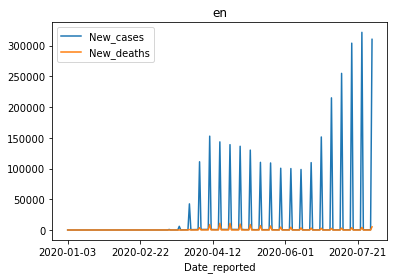

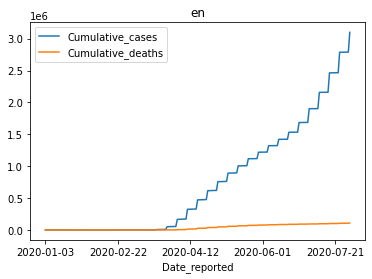

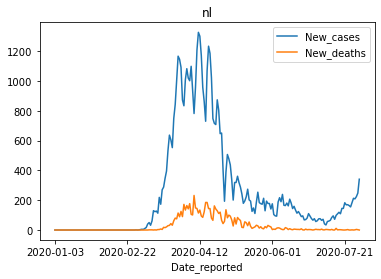

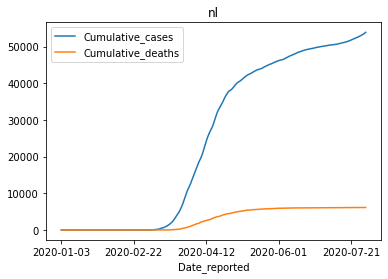

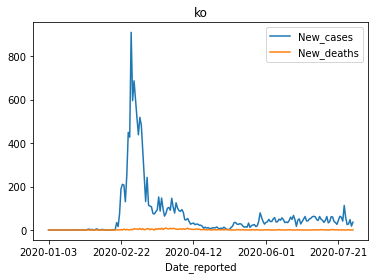

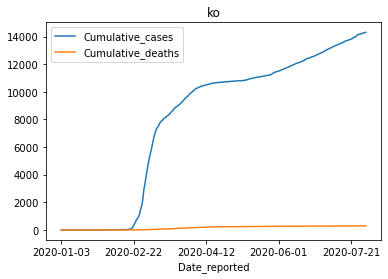

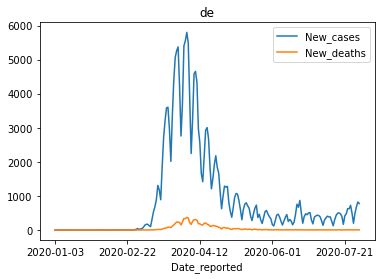

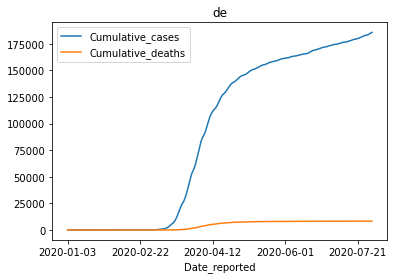

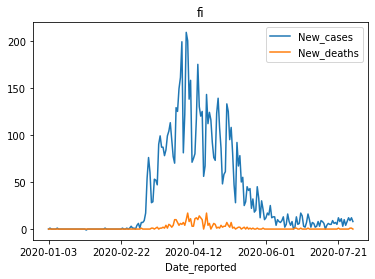

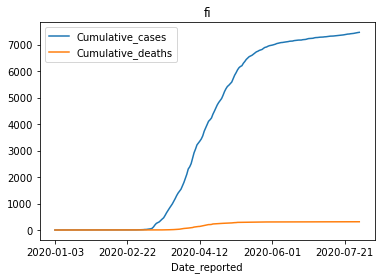

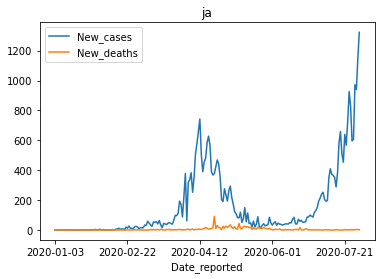

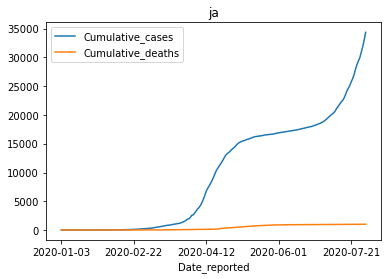

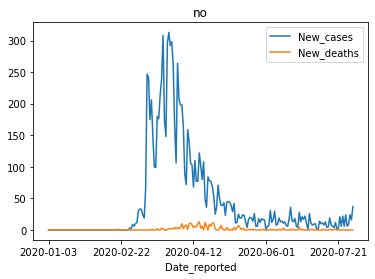

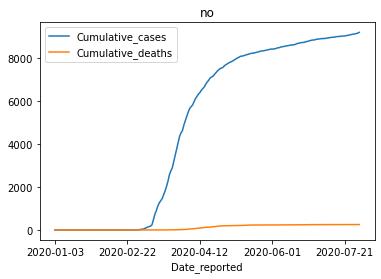

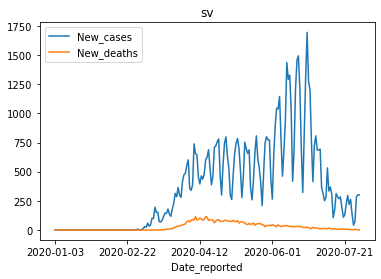

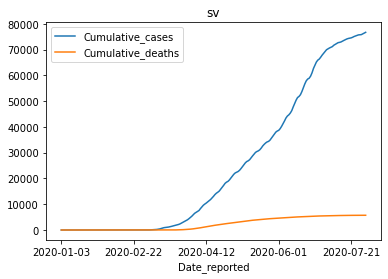

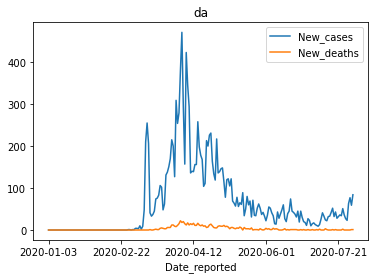

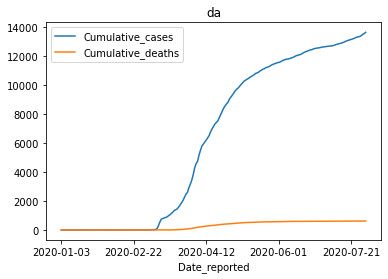

In [16]:
time = covid['en'].index
for i in ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]:
    covid[i][['New_cases','New_deaths']].plot()
    plt.title(i)
    covid[i][['Cumulative_cases','Cumulative_deaths']].plot()
    plt.title(i)
    plt.show()

In [17]:
agg = load_aggregated("./data/aggregated_timeseries.json.gz")

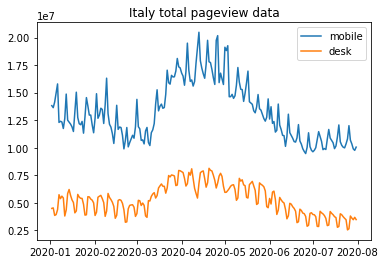

In [18]:
# let's start with italy data
it_pageview_m = agg['it.m']['sum']
it_pageview_m = it_pageview_m[(it_pageview_m.index > '2020-01-01')&(it_pageview_m.index<'2020-08-01')]
plt.plot(it_pageview_m, label='mobile')
it_pageview = agg['it']['sum']
it_pageview = it_pageview[(it_pageview.index > '2020-01-01')&(it_pageview.index<'2020-08-01')]
plt.plot(it_pageview, label='desk')
plt.title('Italy total pageview data')
plt.legend()
plt.show()

In [20]:
# choose the date interval
def pageview_percent(df, start_time, end_time):
    topic_pageview_percent = pd.DataFrame(index = pd.date_range(start=start_time, end=end_time))
    for i in df.keys():
        temp = df[i]['percent']
        temp = temp[(temp.index >= start_time)&(temp.index<=end_time)]
        topic_pageview_percent[i]=temp
    return topic_pageview_percent

topic_pageview_percent = pageview_percent(agg["it"]["topics"],  '2020-01-03', '2020-07-31')

# add covid as a topic
temp = agg["it"]["covid"]['percent']
temp = temp[(temp.index >= '2020-01-03')&(temp.index<='2020-07-31')]
topic_pageview_percent['covid']=temp

In [21]:
topic_pageview_percent.head()

,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,Culture.Media.Media*,Culture.Media.Music,Culture.Media.Radio,Culture.Media.Software,Culture.Media.Television,Culture.Media.Video games,Culture.Performing arts,Culture.Philosophy and religion,Culture.Sports,Culture.Visual arts.Architecture,Culture.Visual arts.Comics and Anime,Culture.Visual arts.Fashion,Culture.Visual arts.Visual arts*,Geography.Geographical,Geography.Regions.Africa.Africa*,Geography.Regions.Africa.Central Africa,Geography.Regions.Africa.Eastern Africa,Geography.Regions.Africa.Northern Africa,Geography.Regions.Africa.Southern Africa,Geography.Regions.Africa.Western Africa,Geography.Regions.Americas.Central America,Geography.Regions.Americas.North America,Geography.Regions.Americas.South America,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.Central Asia,Geography.Regions.Asia.East Asia,Geography.Regions.Asia.North Asia,Geography.Regions.Asia.South Asia,Geography.Regions.Asia.Southeast Asia,Geography.Regions.Asia.West Asia,Geography.Regions.Europe.Eastern Europe,Geography.Regions.Europe.Europe*,Geography.Regions.Europe.Northern Europe,Geography.Regions.Europe.Southern Europe,Geography.Regions.Europe.Western Europe,Geography.Regions.Oceania,History and Society.Business and economics,History and Society.Education,History and Society.History,History and Society.Military and warfare,History and Society.Politics and government,History and Society.Society,History and Society.Transportation,STEM.Biology,STEM.Chemistry,STEM.Computing,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology,covid
2020-01-03,0.098461,0.019657,0.004507,0.008306,0.003638,0.024715,0.006244,0.007954,0.036397,0.114012,0.021856,0.000478,0.006452,0.018727,0.004332,0.005116,0.019777,0.029749,0.006732,0.006529,0.002260,0.021260,0.005668,0.005178,0.001121,0.000342,0.001579,0.000485,0.000215,0.001463,0.029770,0.004466,0.019415,0.000611,0.004638,0.002026,0.001405,0.001083,0.007807,0.005425,0.109509,0.011182,0.060441,0.019041,0.001946,0.011969,0.001252,0.023233,0.016598,0.019163,0.010712,0.009654,0.010312,0.006879,0.007782,0.003919,0.008176,0.000576,0.003573,0.013159,0.006325,0.067741,0.002927,0.014083,0.000017
2020-01-04,0.098285,0.020188,0.004405,0.008162,0.003635,0.025313,0.006336,0.008311,0.036854,0.115281,0.022948,0.000472,0.005693,0.019400,0.004555,0.004762,0.020045,0.028339,0.007045,0.006994,0.002251,0.022327,0.005739,0.005275,0.001146,0.000358,0.001565,0.000590,0.000253,0.001436,0.030010,0.004657,0.020236,0.000625,0.005072,0.002146,0.001489,0.001084,0.007828,0.005740,0.109334,0.011558,0.059187,0.020036,0.002010,0.010524,0.001275,0.024158,0.017167,0.018732,0.010900,0.009239,0.010446,0.006601,0.006779,0.003933,0.007727,0.000592,0.003573,0.012928,0.006360,0.064814,0.002869,0.012410,0.000014
2020-01-05,0.098585,0.021420,0.004297,0.007751,0.003844,0.025562,0.006646,0.008480,0.036879,0.114462,0.022321,0.000464,0.005503,0.019531,0.004281,0.004783,0.020538,0.027985,0.006978,0.007088,0.002352,0.022362,0.005692,0.005462,0.001170,0.000355,0.001673,0.000507,0.000214,0.001362,0.029224,0.004390,0.019577,0.000643,0.005093,0.002149,0.001489,0.001132,0.008076,0.005669,0.109965,0.010909,0.061356,0.020112,0.002134,0.009967,0.001225,0.025349,0.016729,0.018491,0.011258,0.008843,0.010812,0.006555,0.006606,0.004080,0.007300,0.000561,0.003513,0.012830,0.006236,0.064302,0.002885,0.011995,0.000017
2020-01-06,0.097200,0.020983,0.004359,0.007524,0.003802,0.026699,0.007524,0.007991,0.037228,0.114415,0.020638,0.000453,0.005720,0.019697,0.003932,0.004682,0.022220,0.027053,0.007008,0.006612,0.002080,0.022045,0.005620,0.005764,0.001178,0.000399,0.001708,0.000517,0.000221,0.001385,0.030118,0.004120,0.018777,0.000667,0.004793,0.002052,0.001412,0.001135,0.007877,0

In [23]:
total_df = topic_pageview_percent.copy()
total_df['new_deaths'] = covid['it']['New_deaths'].values
total_df['new_cases'] = covid['it']['New_cases'].values

<AxesSubplot:>

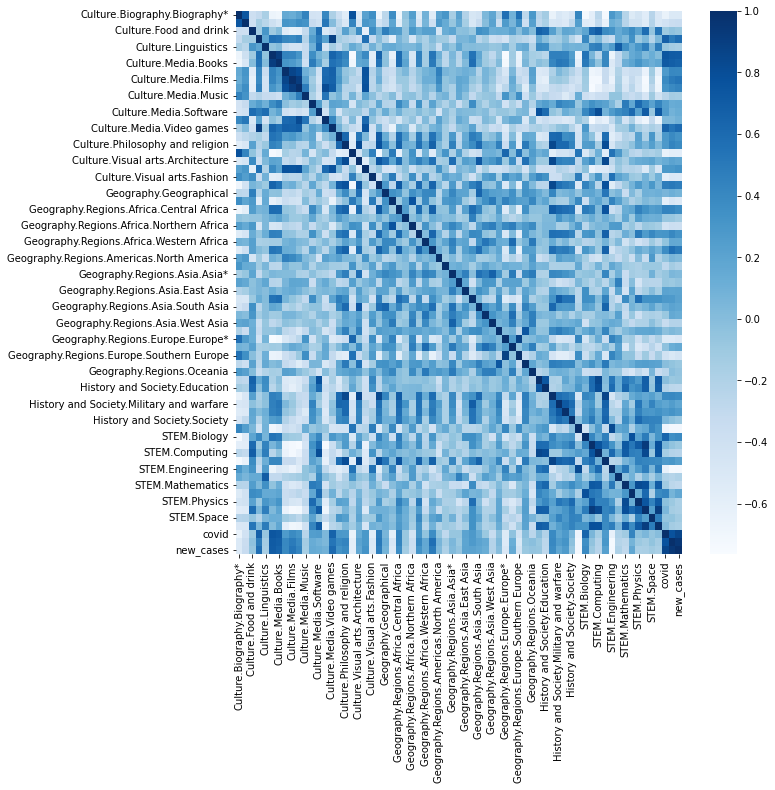

In [24]:
# correlation beween covid deaths/infections and topics
corr = total_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="Blues", fmt=".2f")

In [26]:
corr[['new_cases']].sort_values(by='new_cases')

,new_cases
STEM.Engineering,-0.728056
History and Society.Transportation,-0.714103
Culture.Sports,-0.586930
Geography.Regions.Africa.Africa*,-0.521406
Culture.Visual arts.Fashion,-0.514367
Culture.Biography.Biography*,-0.510134
Geography.Regions.Europe.Europe*,-0.495099
Geography.Regions.Europe.Southern Europe,-0.441069
Geography.Regions.Africa.Northern Africa,-0.377258
Culture.Biography.Women,-0.337913


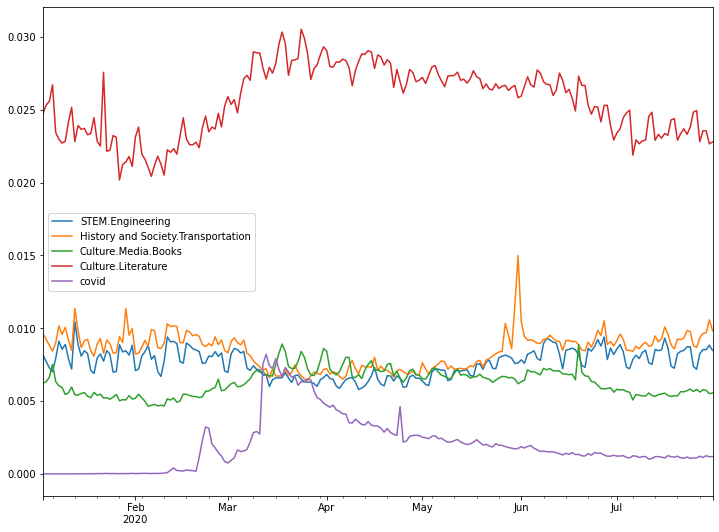

In [27]:
interested_list = ["STEM.Engineering","History and Society.Transportation","Culture.Media.Books",'Culture.Literature','covid']
plt.figure(figsize=(12,9))
for i in interested_list:
    total_df[i].plot(label=i)
    plt.legend()
plt.show()

In [28]:
# how about mobile device?
topic_pageview_percent_m = pageview_percent(agg["it.m"]["topics"],  '2020-01-03', '2020-07-31')
# add covid
temp = agg["it.m"]["covid"]['percent']
temp = temp[(temp.index >= '2020-01-03')&(temp.index<='2020-07-31')]
topic_pageview_percent_m['covid']=temp
# add covid death/cases data
df = topic_pageview_percent_m.copy()
df['new_deaths'] = covid['it']['New_deaths'].values
df['new_cases'] = covid['it']['New_cases'].values
corr = df.corr()
corr[['new_deaths']].sort_values(by='new_deaths')

,new_deaths
STEM.Engineering,-0.754357
Culture.Sports,-0.563416
Geography.Regions.Europe.Europe*,-0.543202
Geography.Regions.Africa.Africa*,-0.503627
Geography.Regions.Europe.Southern Europe,-0.498236
STEM.Libraries & Information,-0.497150
Geography.Regions.Africa.Northern Africa,-0.484653
History and Society.Transportation,-0.477968
Culture.Food and drink,-0.462701
Geography.Regions.Europe.Western Europe,-0.456746


Conclusion: We can see that Covid-19 related pageviews are highly correlated with Covid infections/deaths, other topics are also highly correlated but the reason is blurry and might be hard to explain. We thus want to focus on one specific topic(Medicine&Health), and expore it's relation with Covid dataset. Here, we pay attention to the mental and phsical health pageviews.

### mobility df

In [29]:
# Also need to do data integration, but haven't done yet
google_mobility = pd.read_csv('./data/Global_Mobility_Report.csv')
google_mobility.set_index('date', inplace=True)
google_mobility.head()

C:\Users\jchen\AppData\Local\Temp\ipykernel_58584\4103195843.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  google_mobility = pd.read_csv('./data/Global_Mobility_Report.csv')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,,
2020-02-15,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,0.0,4.0,5.0,0.0,2.0,1.0
2020-02-16,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,1.0,4.0,4.0,1.0,2.0,1.0
2020-02-17,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,-1.0,1.0,5.0,1.0,2.0,1.0
2020-02-18,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,-2.0,1.0,5.0,0.0,2.0,1.0
2020-02-19,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,-2.0,0.0,4.0,-1.0,2.0,1.0


In [30]:
it_mobile = google_mobility[google_mobility['country_region']=='Italy']

<AxesSubplot:xlabel='date'>

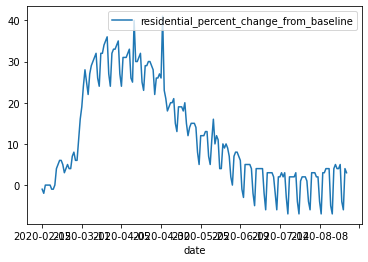

In [31]:
it_mobile[it_mobile['sub_region_1'].isna()][['residential_percent_change_from_baseline']].plot()

### key_words

In [34]:
# collected keywords that we focus on
pd.read_csv('./data/Key_words.csv')

,covid symptoms,mental health,non-covid disease
0,fever,alcoholism,toothache
1,chills,panic disorder,stoke
2,cough,abuse,Cardiovascular diseases
3,shortness of breath,stress,indigestion
4,difficulty breathing,Bipolar disorder,constipation
5,fatigue,Dementia,abdominal pain
6,headache,Schizophrenia,Malnutrition
7,loss of taste,depression,Dermatitis
8,loss of breath,anxiety,HIV
9,loss of smell,addiction,AIDS
